In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)',
            'Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing data
We'll preparing `X, Y` of `Train, Test` set.

In [2]:
timesteps = 360
print(f'timesteps = {timesteps}')

timesteps = 360


In [3]:
feature_used = features
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)

In [4]:
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps, feature_used = feature_used)

dif : 355
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 349
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 343
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 337
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


## Standardize the data
Next, we need to scale the data.

In [5]:
# Scale train set
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)

# Scale test set
X_test_scaled = defaultdict(lambda: [])
Y_test_scaled = defaultdict(lambda: [])

for p in provinces:
    for e in X_test[p]:
        X_test_scaled[p].append(x_train_scalers[p].transform(e))
    for e in Y_test[p]:
        Y_test_scaled[p].append(y_train_scalers[p].transform(e))

## Shaping
Make sure that the data is in the right shape. The `X` shape should be `(#datapoints, #timesteps, #features)`. The `Y` shape should be `(#datapoints, 72)` since each forecast we have to predict next 72 hours.

In [9]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Chanthaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Chiang Mai
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Songkhla
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Khon Kaen
X Train: (1936, 360, 8)
Y Train: (1936, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)



## Building Model

In [10]:
print(f"timesteps : {timesteps}")

timesteps : 360


In [116]:
province = 'Kanchanaburi'
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

# Last check for null values
check = [np.isnan(x_feed).any(), np.isnan(y_feed).any(), 
         np.isnan(x_eval).any(), np.isnan(y_eval).any()]
print(any(check))

False


In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
import tensorflow as tf

n_features = len(feature_used)

# define model
model = Sequential([
    LSTM(200, input_shape=(timesteps, n_features), return_sequences=True),
    Dropout(rate=0.1),
    LSTM(60),
    Dropout(rate=0.1),
    Dense(72, activation='linear')
])

In [118]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.009, momentum=0.9,clipvalue=1.0), loss='mse')

# TensorBoard
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_log_dir = "./my_logs/"+run_id
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                        patience=10, restore_best_weights=True)
# Nan stopping
nan_stop = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(x_feed, y_feed, validation_data=(x_eval, y_eval), 
                    epochs=100, batch_size=32,
                    callbacks=[tensorboard_cb, early_stop, nan_stop])

# tensorboard --logdir=.\my_logs --port=6006

Epoch 1/100
137/137 [==============================] - 335s 2s/step - loss: 0.0319 - val_loss: 0.0235
Epoch 2/100
137/137 [==============================] - 348s 3s/step - loss: 0.0175 - val_loss: 0.0206
Epoch 3/100
137/137 [==============================] - 375s 3s/step - loss: 0.0147 - val_loss: 0.0194
Epoch 4/100
137/137 [==============================] - 368s 3s/step - loss: 0.0134 - val_loss: 0.0183
Epoch 5/100
137/137 [==============================] - 337s 2s/step - loss: 0.0118 - val_loss: 0.0170
Epoch 6/100
137/137 [==============================] - 362s 3s/step - loss: 0.0108 - val_loss: 0.0156
Epoch 7/100
137/137 [==============================] - 399s 3s/step - loss: 0.0099 - val_loss: 0.0144
Epoch 8/100
137/137 [==============================] - 409s 3s/step - loss: 0.0090 - val_loss: 0.0134
Epoch 9/100
137/137 [==============================] - 411s 3s/step - loss: 0.0085 - val_loss: 0.0125
Epoch 10/100
137/137 [==============================] - 409s 3s/step - loss: 0.008

KeyboardInterrupt: 

In [122]:
#model.save(f"./Models/{province}_{run_id}.h5")

## Evaluate on test data

In [119]:
model.evaluate(x_eval, y_eval)

46/46 [==============================] - 26s 575ms/step - loss: 0.0097


0.009666935540735722

In [120]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)

for i in range(len(pred)):
    p = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = Y_test[province][i].values
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Kanchanaburi


12.275219890665648

province = Kanchanaburi


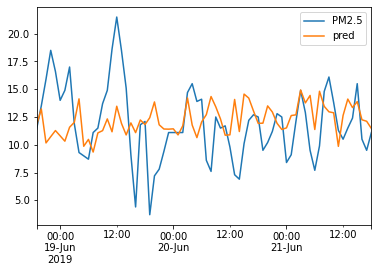

In [130]:
i = 369
print('province =',province)
h = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

In [129]:
np.argmin(rmse)

369

## Save the model
- **Bangkok** : `./Models/Bangkok_run_2021_04_26-13_20_42_final_26Apr.h5` (11.98)
    - `./Models/Chiang Mai_run_2021_04_26-19_56_00_final_26Apr.h5` (10.40)
    - all features
    - 360 timesteps
- **Chanthaburi** : `./Models/Chanthaburi_run_2021_04_26-10_42_58_final_26Apr1155.h5` (8.89) 
    - all features
   - 360 timesteps
- **Songkhla** : `./Models/Songkhla_run_2021_04_25-22_41_22.h5` (7.96)
    - all features
    - 360 timesteps 
- **Kanchanaburi** : `./Models/Kanchanaburi_run_2021_04_26-22_18_39_final_26Apr.h5` (12.27)
    - all features
    - 360 timesteps

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx